In [38]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F



from torch.utils.data import Subset

device_type = 'cuda' if torch.cuda.is_available else 'cpu'
# device_type = 'cpu'
device = torch.device(device_type)
print(device_type)


cuda


In [39]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [40]:
%cd drive/MyDrive/ml_physics/pset_2

!pwd

[Errno 2] No such file or directory: 'drive/MyDrive/ml_physics/pset_2'
/content/drive/MyDrive/ml_physics/pset_2
/content/drive/My Drive/ml_physics/pset_2


# Problem 1

a) Instantiate a sequence to sequence transformer (self-attention) using a standard API (tensorflow, pytorch, etc). Verify with some examples that it is permutation equivariant.

b) Prove analytically using the defining equations of self-attention that the transformer architecture is permutation equivariant.

c) Repeat (b) for multi-headed attention.

## 1(a)

Let's start with a simple self-attention block, which can be generated with the `nn.MultiheadAttention` module in PyTorch. We will leave all the weights untouched. In essence, we want to demonstrate that we can generate some $Q, K, V$ matrices, permute the elements, and the output should permute in the same manner.

In [41]:
d_model = 32
nhead = 4

# initialize a basic multi-headed attention as an example

transformer = nn.MultiheadAttention(embed_dim=d_model, num_heads=nhead)

seq_length = 10
batch_size = 1


# we really don't care about what the Q, K, V matrices are
# so just generate them randomly



for i in range(10):
    q = torch.randn(seq_length, batch_size, d_model)
    k = torch.randn(seq_length, batch_size, d_model)
    v = torch.randn(seq_length, batch_size, d_model)

    original_output, _= transformer(q, k, v)



    perm = torch.randperm(seq_length)
    q_perm = q[perm]
    k_perm = k[perm]
    v_perm = v[perm]

    new_output, _ = transformer(q_perm, k_perm, v_perm)

    equivariance = torch.allclose(original_output[perm], new_output, atol=1e-6)
    print("Equivariant? ", equivariance)

Equivariant?  True
Equivariant?  True
Equivariant?  True
Equivariant?  True
Equivariant?  True
Equivariant?  True
Equivariant?  True
Equivariant?  True
Equivariant?  True
Equivariant?  True


We saw that for 10 different $Q, K, V$ matrices, they are all equivariant under some random transformation.

## 1(b)
Let's analyze the basic definition of self-attention; as provided by the paper *Attention is All You Need*, we have

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

We want to permute these, so define permutation operator $\Pi$ as our square matrix encoding a permutation of our choosing; the important part is that $Q$, $K$, and $V$ all undergo the same permutation. Note that $\Pi \Pi^T = \mathbf{1}$


\begin{align*}
\text{Attention}(\Pi Q, \Pi K, \Pi V) &= \text{softmax}\left(\frac{\Pi Q K^T \Pi^T}{\sqrt{d_k}}\right) \Pi V\\

\end{align*}

Note the term $\Pi Q K^T \Pi^T$ is in essence a dot product; each term pairwise gets permuted to the same location, so the dot product remains the same. Therefore, $\Pi QK^T \Pi^T = QK^T$ and we have,

$$\text{softmax}\left(\frac{\Pi Q K^T \Pi^T}{\sqrt{d_k}}\right) \Pi V$$

Since the $\text{softmax}$ term is simply a scalar, we can move it to the outside to get the conclusion that,

$$\text{Attention}(\Pi Q, \Pi K, \Pi V)  = \Pi \text{Attention}(Q, K, V)$$

proving that is permutation equivariant.

## 1(c)

For multi-headed attention, we have our definition from the paper:

$$\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \cdots \text{head}_h)W^O$$

for

$$\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)$$

So for each head of attention, we know from 1(b) that

$$\text{head}_i(\Pi Q, \Pi K, \Pi V ) = \Pi \text{Attention}(QW_i^Q, KW_i^K, VW_i^V) = \Pi \text{head}_i $$

So from our original definition of multi-headed attention we have,
$$\text{MultiHead}(\Pi Q, \Pi K, \Pi V ) = \text{Concat}(\Pi\text{head}_1, \cdots \Pi\text{head}_h)W^O = \Pi \text{Concat}(\text{head}_1, \cdots \text{head}_h)W^O$$

giving the desired result

$$\boxed{\text{MultiHead}(\Pi Q, \Pi K, \Pi V ) = \Pi \text{MultiHead}( Q, K, V )}$$

# Problem 2

a) Train the MNIST VAE from class. Illustrate with some example scans across the 2d latent space how the digits morph from one into another.

b) Train a vanilla autoencoder on MNIST and compare the latent space to the VAE.


## 2(a)

Here we've built a VAE from scratch (I chose to do this so I could learn what was going on under the hood). First, let's instantiate the data.

In [42]:

# Import MNIST dataset

from torchvision import datasets
import torchvision.transforms as T
from torch.utils.data import DataLoader


mnist_data = datasets.MNIST(root='data', train=True,
                            transform = T.Compose(
                                        [T.ToTensor(),
                                        T.Lambda(lambda x: x.view(-1))]
                                        ),
                            download=True)

# Parameters for training
batch_size = 100
batch_size_test = 100
num_epochs = 10


# Try using dataloader module to randomly provide datapts from dataset

size_mnist = 28*28

100%|██████████| 9.91M/9.91M [00:00<00:00, 14.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 498kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.62MB/s]


Now we'll architect the VAE.

In [43]:
# Architecting the variational autoencoder

class VAE_MNIST(nn.Module):
    def __init__(self, latent_space_dim):
        super(VAE_MNIST, self).__init__()

        # define the encoder
        layer_one_size = 500
        layer_two_size = 200
        layer_three_size = 20

        self.fc1 = nn.Linear(size_mnist, layer_one_size)
        self.fc2 = nn.Linear(layer_one_size, layer_two_size)
        self.fc3 = nn.Linear(layer_two_size, layer_three_size)
        self.mean = nn.Linear(layer_three_size, latent_space_dim)
        self.std_dev = nn.Linear(layer_three_size, latent_space_dim)


        # define decoder layers

        self.dfc1 = nn.Linear(latent_space_dim, layer_three_size)
        self.dfc2 = nn.Linear(layer_three_size, layer_two_size)
        self.dfc3 = nn.Linear(layer_two_size, layer_one_size)
        self.img = nn.Linear(layer_one_size, size_mnist)

        # Bring the image down multiple layers into the latent dimensional space

    def encoder(self, x):


        h = F.leaky_relu(self.fc1(x))
        h = F.leaky_relu(self.fc2(h))
        h = self.fc3(h)
        return self.mean(h), self.std_dev(h)


    # Performs the reparameterization trick

    def sampling(self, mu, log_variance):
        std = torch.exp(0.5*log_variance)
        epsilon = torch.randn_like(std)
        return mu + std*epsilon # double check if this is allowed

    # Bring point in latent dimensional space to image space

    def decoder(self, x):
        h = F.leaky_relu(self.dfc1(x))
        h = F.leaky_relu(self.dfc2(h))
        h = F.leaky_relu(self.dfc3(h))

        return torch.sigmoid(self.img(h))

    # Forward step

    def forward(self, x):
        # encode in latent space
        mu, log_variance = self.encoder(x)
        # sample from the distribution
        z = self.sampling(mu, log_variance)
        # decode
        return self.decoder(z), mu, log_variance

    def loss(self, output, input, mu, log_variance):
        # Since the prior is just the normal dist. the KL divergence takes on the form
        KL = -1/2*torch.sum(1+log_variance-mu.pow(2)-log_variance.exp())
        # Binary cross-entropy is same as usual
        BCE = F.binary_cross_entropy(output, input, reduction='sum')
        return BCE+KL

In [44]:

# Define autoencoder model

mnist_vae = VAE_MNIST(latent_space_dim=2)
mnist_vae_optim = torch.optim.Adam(mnist_vae.parameters())

# train the model


def vae_train(model, epoch_size, dataset, optimizer):
    model.train()
    dataloader = DataLoader(dataset=Subset(mnist_data, np.random.choice(len(mnist_data), 5000)), batch_size=100, shuffle=True)
    for epoch in range(epoch_size):
        for input, target in dataloader:
            optimizer.zero_grad()
            output, mu, log_variance = model(input)

            loss = model.loss(output, input, mu, log_variance)
            loss.backward()
            optimizer.step()

In [45]:
vae_train(mnist_vae, 20, mnist_data, mnist_vae_optim)

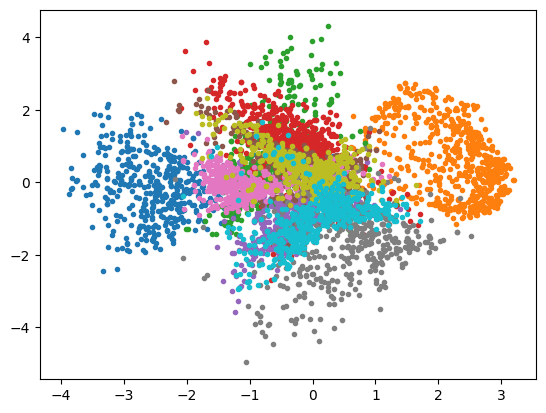

In [46]:
# Map out all of the different numbers in our latent space


# plot_dataloader = DataLoader(dataset=Subset(mnist_data, np.random.choice(len(mnist_data), 1000)), batch_size=1, shuffle=True)
# colors = plt.cm.tab10(np.linspace(0,1,10))


# xlist  = []
# ylist = []
# for input, target in plot_dataloader:
#     result, mu, log_variance = mnist_vae(input)
#     with torch.no_grad():
#         plt.scatter(mu.numpy()[0][0], mu.numpy()[0][1], color = colors[target])


# plt.show()


# Map out all of the different numbers in our latent space


colors = plt.cm.tab10(np.linspace(0,1,10))


empty = []
list_coords = [[[],[]] for _ in range(10)]

with torch.no_grad():
    for input, target in Subset(mnist_data, np.random.choice(len(mnist_data),5000)):
        result, mu, log_variance = mnist_vae(input)
        list_coords[target][0].append(mu[0])
        list_coords[target][1].append(mu[1])

    for target, element in enumerate(list_coords):
        plt.scatter(element[0], element[1], color = colors[target], marker = '.')
plt.show()


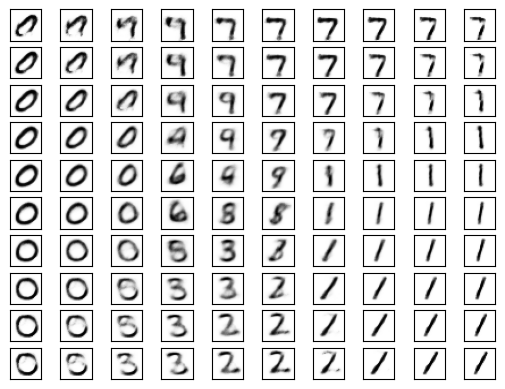

In [47]:
# Now attempt to generate a number from the graph

# new_image = new_image.reshape((28,28))
# with torch.no_grad():
#     plt.imshow(new_image.numpy(), cmap='Greys')

# grid


rows = 10
cols = 10

xlist = np.linspace(-4, 4, rows)
ylist = np.linspace(-4, 4, cols)

fig, axes = plt.subplots(rows, cols)

xpts, ypts = np.meshgrid(xlist, ylist)


with torch.no_grad():
    for i, row in enumerate(xpts):
        for j, item in enumerate(xpts):
            new_img = mnist_vae.decoder(torch.tensor([xpts[i][j], ypts[i][j]], dtype=torch.float))
            new_img = new_img.reshape((28, 28))
            im = axes[i][j].imshow(new_img.numpy(), cmap = 'Greys')
            axes[i][j].set_xticks([])
            axes[i][j].set_yticks([])


## 2(b)

Here, let's make a standard autoencoder

In [48]:
# Compare to a standard autoencoder and see the results


class standard_autoencoder(nn.Module):
    def __init__(self, latent_space_dim):
        super(standard_autoencoder, self).__init__()

        # define the encoder
        layer_one_size = 100
        layer_two_size = 50
        layer_three_size = 20

        self.fc1 = nn.Linear(size_mnist, layer_one_size)
        self.fc2 = nn.Linear(layer_one_size, layer_two_size)
        self.fc3 = nn.Linear(layer_two_size, layer_three_size)
        self.mean = nn.Linear(layer_three_size, latent_space_dim)
        self.std_dev = nn.Linear(layer_three_size, latent_space_dim)


        # define decoder layers

        self.dfc1 = nn.Linear(latent_space_dim, layer_three_size)
        self.dfc2 = nn.Linear(layer_three_size, layer_two_size)
        self.dfc3 = nn.Linear(layer_two_size, layer_one_size)
        self.img = nn.Linear(layer_one_size, size_mnist)


        # Bring the image down multiple layers into the latent dimensional space

    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        return self.mean(h), self.std_dev(h)

    # Bring point in latent dimensional space to image space

    def decoder(self, x):
        h = F.relu(self.dfc1(x))
        h = F.relu(self.dfc2(h))
        h = F.relu(self.dfc3(h))

        return torch.sigmoid(self.img(h))

    # Forward step

    def forward(self, x):
        # encode in latent space
        mu, log_variance = self.encoder(x)
        # decode
        return self.decoder(mu), mu, log_variance

    def loss(self, output, input, mu, log_variance):
        # Just the binary cross-entropy loss
        BCE = F.binary_cross_entropy(output, input, reduction='sum')
        return BCE


In [49]:
# train this normal autoencoder

mnist_autoencoder = standard_autoencoder(latent_space_dim=2)
mnist_autoencoder_optimizer = torch.optim.Adam(mnist_autoencoder.parameters())

vae_train(model=mnist_autoencoder, epoch_size=20, dataset=mnist_data, optimizer=mnist_autoencoder_optimizer)

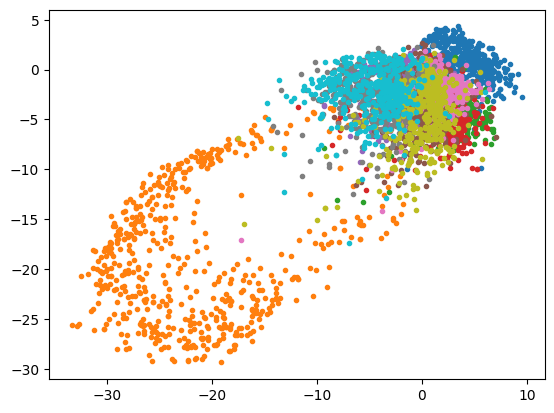

In [50]:


colors = plt.cm.tab10(np.linspace(0,1,10))

empty = []
list_coords = [[[],[]] for _ in range(10)]

with torch.no_grad():
    for input, target in Subset(mnist_data, np.random.choice(len(mnist_data),5000)):
        result, mu, log_variance = mnist_autoencoder(input)
        list_coords[target][0].append(mu[0])
        list_coords[target][1].append(mu[1])

    for target, element in enumerate(list_coords):
        plt.scatter(element[0], element[1], color = colors[target], marker = '.')
plt.show()


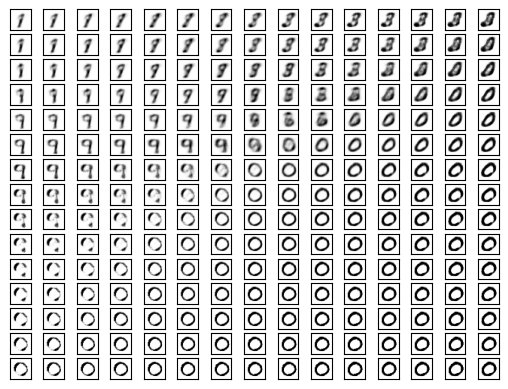

In [51]:
# Plot one of those cool diagrams


rows = 15
cols = 15

xlist = np.linspace(-10, 10, rows)
ylist = np.linspace(-10, 20, cols)

fig, axes = plt.subplots(rows, cols)

xpts, ypts = np.meshgrid(xlist, ylist)

# plt.plot(xpts, ypts)


with torch.no_grad():
    for i, row in enumerate(xpts):
        for j, item in enumerate(xpts):
            new_img = mnist_autoencoder.decoder(torch.tensor([xpts[i][j], ypts[i][j]], dtype=torch.float))
            new_img = new_img.reshape((28, 28))
            im = axes[i][j].imshow(new_img.numpy(), cmap = 'Greys')
            axes[i][j].set_xticks([])
            axes[i][j].set_yticks([])


# Problem 3

a) Train a vanilla GAN, WGAN and variational autoencoder on MNIST data. You can use the examples provided in class. Generate samples from each and train a binary classifier on each vs the reference data. What AUC scores do you get?

b) Train a log posterior metric on all three models. Which performs best?

c) Train a supervised classifier on MNIST and use this to diagnose mode collapse in the three generative models. How do they fare?

## 3(a)

We already have trained a VAE on MNIST data. We will copy the WGAN and GAN weights from the models provided on the website and convert them to `torch` objects for convenience.

In [52]:
num_samples = 1000


In [56]:
# import WGAN
import tensorflow
from keras.models import load_model
import torchvision.transforms as transforms


In [57]:
import tensorflow as tf
TRAIN_BUF=60000
BATCH_SIZE=64
TEST_BUF=10000
DIMS = (32,32,1)
N_TRAIN_BATCHES =int(TRAIN_BUF/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)

class WGAN(tf.keras.Model):
    """[summary]
    I used github/LynnHo/DCGAN-LSGAN-WGAN-GP-DRAGAN-Tensorflow-2/ as a reference on this.

    Extends:
        tf.keras.Model
    """

    def __init__(self, **kwargs):
        super(WGAN, self).__init__()
        self.__dict__.update(kwargs)

        self.gen = tf.keras.Sequential(self.gen)
        self.disc = tf.keras.Sequential(self.disc)

    def generate(self, z):
        return self.gen(z)

    def discriminate(self, x):
        return self.disc(x)

    def compute_loss(self, x):
        """ passes through the network and computes loss
        """
        ### pass through network
        # generating noise from a uniform distribution

        z_samp = 2*tf.random.uniform([x.shape[0], 1, 1, self.n_Z])-1

        # run noise through generator
        x_gen = self.generate(z_samp)
        # discriminate x and x_gen
        logits_x = self.discriminate(x)
        logits_x_gen = self.discriminate(x_gen)

        # gradient penalty
        d_regularizer = self.gradient_penalty(x, x_gen)
        ### losses
        disc_loss = (
            tf.reduce_mean(logits_x)
            - tf.reduce_mean(logits_x_gen)
            + d_regularizer * self.gradient_penalty_weight
        )

        # losses of fake with label "1"
        gen_loss = tf.reduce_mean(logits_x_gen)

        return disc_loss, gen_loss

    def compute_gradients(self, x):
        """ passes through the network and computes loss
        """
        ### pass through network
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            disc_loss, gen_loss = self.compute_loss(x)

        # compute gradients
        gen_gradients = gen_tape.gradient(gen_loss, self.gen.trainable_variables)

        disc_gradients = disc_tape.gradient(disc_loss, self.disc.trainable_variables)

        return gen_gradients, disc_gradients

    def apply_gradients_gen(self, gen_gradients):

        self.gen_optimizer.apply_gradients(
            zip(gen_gradients, self.gen.trainable_variables)
        )

    def apply_gradients_disc(self, disc_gradients):

        self.disc_optimizer.apply_gradients(
            zip(disc_gradients, self.disc.trainable_variables)
        )

    def gradient_penalty(self, x, x_gen):
        epsilon = tf.random.uniform([x.shape[0], 1, 1, 1], 0.0, 1.0)
        x_hat = epsilon * x + (1 - epsilon) * x_gen
        with tf.GradientTape() as t:
            t.watch(x_hat)
            d_hat = self.discriminate(x_hat)
        gradients = t.gradient(d_hat, x_hat)
        ddx = tf.sqrt(tf.reduce_sum(gradients ** 2, axis=[1, 2]))
        d_regularizer = tf.reduce_mean((ddx - 1.0) ** 2)
        return d_regularizer

    @tf.function
    def train_disc(self, train_x):
        #train discriminator
        _, disc_gradients = self.compute_gradients(train_x)
        self.apply_gradients_disc(disc_gradients)

    def train_gen(self, train_x):
    #train generator
        gen_gradients, _ = self.compute_gradients(train_x)
        self.apply_gradients_gen(gen_gradients)


N_Z = 128

generator = [
    tf.keras.layers.Dense(units=4 * 4 * 256,activation='relu'),
#    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Reshape(target_shape=(4, 4, 256)),
    tf.keras.layers.Conv2DTranspose(
        filters=128, kernel_size=5, strides=(2, 2), padding="SAME",activation='relu'
    ),
#    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=5, strides=(2, 2), padding="SAME",activation='relu'
    ),
#    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=5, strides=(2, 2), padding="SAME", activation="tanh"
    ),
]

discriminator = [
    tf.keras.layers.InputLayer(input_shape=DIMS),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=5, strides=(2, 2)
    ),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Conv2D(
        filters=128, kernel_size=5, strides=(2, 2)
    ),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Conv2D(
        filters=256, kernel_size=5, strides=(2, 2)
    ),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1),
]

# optimizers
#gen_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)
#disc_optimizer = tf.keras.optimizers.RMSprop(0.0005)# train the model
gen_optimizer = tf.keras.optimizers.Adam(1e-3, beta_1=0.5, beta_2=0.9)
disc_optimizer = tf.keras.optimizers.Adam(1e-3, beta_1=0.5, beta_2=0.9)


# model
wgan = WGAN(
    gen = generator,
    disc = discriminator,
    gen_optimizer = gen_optimizer,
    disc_optimizer = disc_optimizer,
    n_Z = N_Z,
    gradient_penalty_weight = 10.0
)

# wgan.load_weights('test.h5')
dummy_z = tf.random.normal([1, 1, 1, wgan.n_Z])
_ = wgan.gen(dummy_z)  # This builds the generator


wgan.gen.load_weights('wgan.weights.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [58]:
# generate gan


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.utils import plot_model

# define the standalone generator model
def define_gan_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model


gan = define_gan_generator(latent_dim=100)

gan.load_weights("gan.weights.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [59]:
# example of defining and using the generator model
from numpy import zeros
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from matplotlib import pyplot


# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input,verbose=0)
	# create 'fake' class labels (0)
	# y = zeros((n_samples, 1))
	return X.reshape(n_samples, 28*28, 1)


def generate_gan_samples (model = gan, num_samples = 1000):
  gan_samples = generate_fake_samples(gan, latent_dim=100, n_samples=num_samples)
  gan_samples = torch.from_numpy(gan_samples).squeeze(dim=2)

gan_samples = generate_gan_samples(model = gan, num_samples = 1000)
print(gan_samples.shape)

torch.Size([1000, 784])


In [60]:
def plot_reconstruction(model, nex=8, zm=2):
    z_samp = 2*tf.random.uniform([BATCH_SIZE, 1, 1, N_Z])-1
    samples = model.generate(z_samp)
    fig, axs = plt.subplots(ncols=nex, nrows=1, figsize=(zm * nex, zm))
    for axi in range(nex):
        axs[axi].matshow(
                    samples.numpy()[axi].squeeze(), cmap=plt.cm.Greys, vmin=-1, vmax=1
                )
        axs[axi].axis('off')
    plt.show()


def generate_wgan_samples(model, num_samples):
  z_samp = 2*tf.random.uniform([num_samples, 1, 1, N_Z])-1
  samples = model.generate(z_samp)
  torch_tensor = torch.from_numpy(samples.numpy()).unsqueeze(dim=1).squeeze(dim=4)
  unflattened = F.interpolate(torch_tensor, size=(28,28), mode='bilinear', align_corners=False).squeeze(dim=1)
  return unflattened.reshape(num_samples, 28*28)

wgan_samples = generate_wgan_samples(model=wgan, num_samples=num_samples)

print(wgan_samples.shape)

torch.Size([1000, 784])


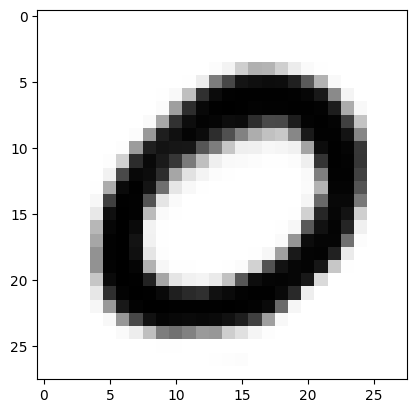

In [76]:
# generate a bunch of samples from the VAE

# multiply by 2 to increase the variance a bit to match the range in our particular VAE

# create 1000 samples


def generate_vae_samples(model=mnist_vae, num_samples=1000):
  random_samples_vae = torch.randn((num_samples, 2))*3
  random_numbers_vae = model.decoder(random_samples_vae)
  return random_numbers_vae


random_numbers_vae = generate_vae_samples(model = mnist_vae, num_samples = num_samples)

with torch.no_grad():
    plt.imshow(random_numbers_vae[10].reshape((28,28)), cmap="Grays")


In [62]:
# basic binary classifier for VAE

from torch.utils.data import ConcatDataset, Dataset, TensorDataset

def binary_train(model, epoch_size, dataset, optimizer):
    model.train()
    dataloader = DataLoader(dataset=dataset, batch_size=100, shuffle=True)
    for epoch in range(epoch_size):
        for vectors, target in dataloader:
            optimizer.zero_grad()
            outputs = model(vectors)
            loss = F.binary_cross_entropy_with_logits(outputs, target.unsqueeze(1))
            loss.backward()
            optimizer.step()
# Create a method to test our model

# basic CNN

def basic_classifier():
  return nn.Sequential(
    nn.Linear(size_mnist, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 1)
)

classifier_vae = basic_classifier()



In [63]:
# Make a dataset for VAEs

vae_dataset = {}
vae_dataset_test = {}



with torch.no_grad():
    vae_dataset = TensorDataset(random_numbers_vae.detach(), torch.zeros(num_samples))
    vae_dataset_test = TensorDataset(random_numbers_vae.detach(), torch.zeros(num_samples))


classifier_vae_optimizer = torch.optim.Adam(classifier_vae.parameters())

relabeled_mnist = TensorDataset((mnist_data.data/255).view(len(mnist_data), 28*28), torch.ones(len(mnist_data)))

vae_dataset = ConcatDataset([vae_dataset, Subset(relabeled_mnist, np.random.choice(len(relabeled_mnist), num_samples))])

# make a teset datset with a different random set from MNIST

vae_dataset_test  = ConcatDataset([vae_dataset_test, Subset(relabeled_mnist, np.random.choice(len(relabeled_mnist), num_samples))])

In [64]:
# classifier for WGAN

classifier_wgan = basic_classifier()

classifier_wgan_optimizer = torch.optim.Adam(classifier_wgan.parameters())

In [65]:
# classifier for GAN

classifier_gan = basic_classifier()

classifier_gan_optimizer = torch.optim.Adam(classifier_gan.parameters())

In [66]:
# dataset for WGAN

wgan_og = TensorDataset(wgan_samples, torch.zeros(num_samples))

wgan_dataset = ConcatDataset([wgan_og, Subset(relabeled_mnist, np.random.choice(len(relabeled_mnist), num_samples))])

# test with different random sample
wgan_dataset_test = ConcatDataset([wgan_og, Subset(relabeled_mnist, np.random.choice(len(relabeled_mnist), num_samples))])

In [67]:
#dataset for GAN

gan_og = TensorDataset(gan_samples, torch.zeros(num_samples))

gan_dataset = ConcatDataset([gan_og, Subset(relabeled_mnist, np.random.choice(len(relabeled_mnist), num_samples))])

# test with different random sample
gan_dataset_test = ConcatDataset([gan_og, Subset(relabeled_mnist, np.random.choice(len(relabeled_mnist), num_samples))])



In [68]:
# train classifier for VAE

binary_train(classifier_vae, 100, vae_dataset, classifier_vae_optimizer)

In [69]:
# train classifier for WGAN

binary_train(classifier_wgan, 50, wgan_dataset, classifier_wgan_optimizer)

In [70]:
# train classifier for GAN

binary_train(classifier_gan, 50, gan_dataset, classifier_gan_optimizer)

In [71]:
from sklearn.metrics import auc, roc_curve as roc

def calc_roc(model, test_dataset):
    model.eval()
    y_true = []
    y_score = []
    with torch.no_grad():
        for vector, label in test_dataset:
            outputs = model(vector)
            y_true.append(label)
            y_score.append(outputs.numpy())

    fpr, tpr, thresholds = roc(y_true=y_true, y_score=y_score)
    auc_score = auc(fpr, tpr)

    return fpr, tpr, auc_score


with torch.no_grad():
    vae_fpr, vae_tpr, vae_auc = calc_roc(classifier_vae, vae_dataset_test)

print(vae_auc)


0.989898


As we can see, for our VAE, they are very easily seperable with even the most basic binary classifier.

In [72]:
wgan_fpr, wgan_tpr, wgan_auc = calc_roc(classifier_wgan, wgan_dataset_test )
print(wgan_auc)


1.0


For the WGAN the story isn't much better; we achieve perfect separation. As we can see, our WGAN isn't doing too great.

In [73]:
gan_fpr, gan_tpr, gan_auc = calc_roc(classifier_gan, gan_dataset_test )
print(gan_auc)

0.995736


And for the normal GAN, it's the same story; we can easily tell the GAN images from the acutal MNIST images. This isn't particularly surprising, as we can visually recognize they're quite different.

## 2(b)

We will now use the log-posterior metric to see which model performs the best.

In [ ]:
# We will start by generating a training dataset for our model:




## 2(c)

Now, let's train a classifier on MNIST; this will allow us to analyze mode collapse on our VAE, GAN, and WGAN

In [74]:
# MNIST classifier with one-hot encoding


num_categories  = 10

classifier_mnist = nn.Sequential(

    nn.Linear(size_mnist, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, num_categories)
)

def mnist_train(model, epoch_size, dataset, optimizer):
    model.train()
    dataloader = DataLoader(dataset=dataset, batch_size=100, shuffle=True)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(epoch_size):
        for vectors, target in dataloader:
            optimizer.zero_grad()
            outputs = model(vectors)
            # target_one_hot = F.one_hot(target, num_classes=num_categories)
            loss = loss_fn(outputs, target)
            loss.backward()
            optimizer.step()

mnist_optimizer = torch.optim.Adam(classifier_mnist.parameters())

mnist_train(model=classifier_mnist, epoch_size=20, dataset=mnist_data, optimizer=mnist_optimizer)

(array([208., 262.,  73.,  79.,  38.,  36.,  19., 200.,  43.,  42.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

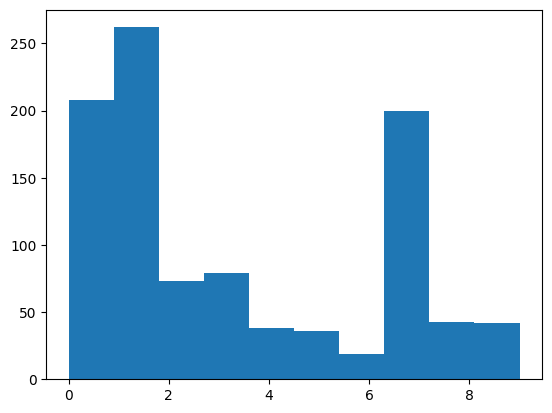

In [75]:
counts_vae  = torch.argmax(classifier_mnist(random_numbers_vae), dim=1)

plt.hist(counts_vae.numpy())

As we can see with the VAE, we have some severe mode collapse. We don't produce a lot of 2s, 3s, and the 0, 1, and 7 are produced quite a bit more frequently.